# XGBoost

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned dataset
df_clean = pd.read_csv("./data/pred_maintenance_cleaned.csv")

# Feature/target split
X = df_clean.drop(columns=['Machine failure'])
y = df_clean['Machine failure']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Model Training

In [5]:
# Clean column names
X_train.columns = X_train.columns.astype(str).str.replace('[\[\]<>]', '', regex=True)
X_test.columns = X_test.columns.astype(str).str.replace('[\[\]<>]', '', regex=True)


In [6]:
import xgboost as xgb
import time

# Initialize model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Measure training time
start_time = time.time()
xgb_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Training time: {training_time:.4f} seconds")


Training time: 0.1198 seconds


/Users/sherry/opt/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:43:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Predict and evaluate

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



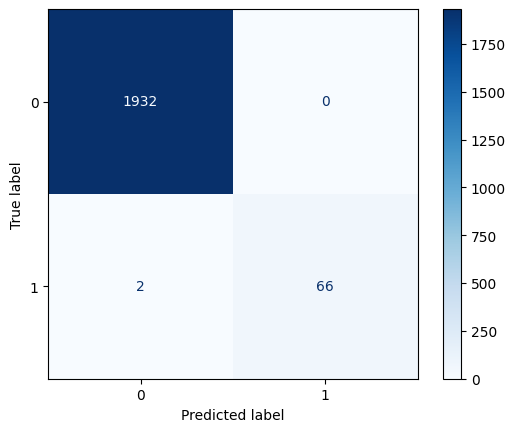

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print full report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_model.classes_)
disp.plot(cmap="Blues")


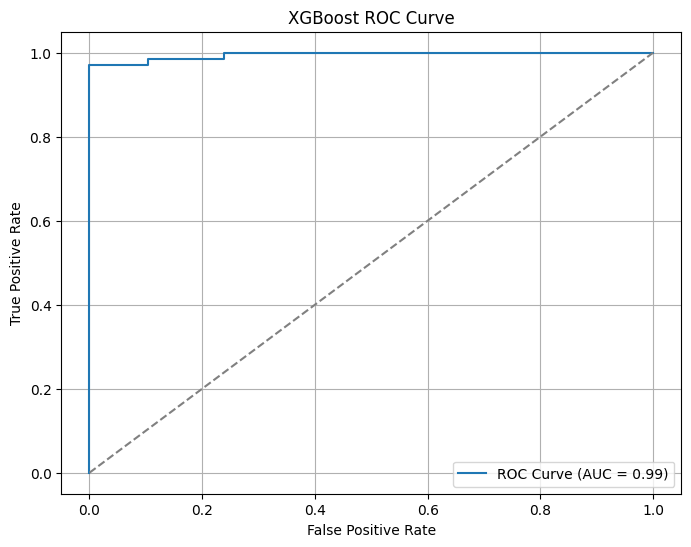

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict probabilities for class 1
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.grid()
plt.show()


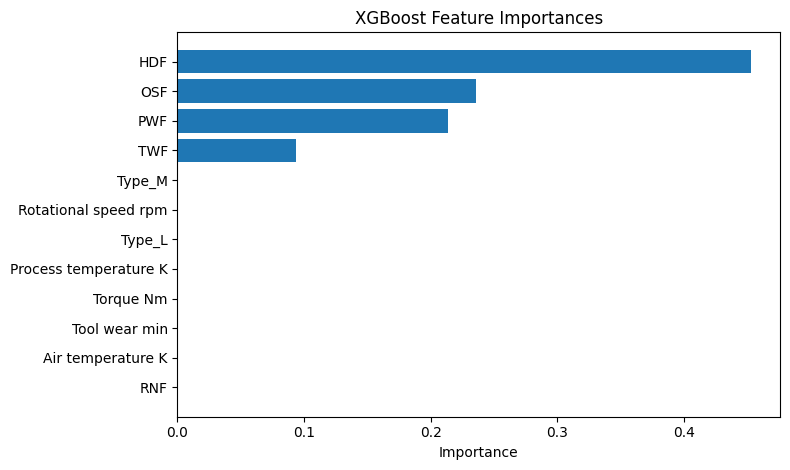

In [10]:
import numpy as np

importances = xgb_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, len(feature_names) * 0.4))
plt.barh(range(len(importances)), importances[sorted_idx], align="center")
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()


In [11]:
import csv

# Select key metrics from the report
metrics = {
    "Model": "XGBoost",
    "Accuracy": report["accuracy"],
    "Precision": report["1"]["precision"],
    "Recall": report["1"]["recall"],
    "F1-score": report["1"]["f1-score"],
    "Training Time (s)": training_time
}

# Define file path
output_path = "./data/xgb_metrics.csv"

# Save to CSV
with open(output_path, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

print(f"Metrics saved to {output_path}")


Metrics saved to ./data/xgb_metrics.csv
